In [9]:
import pandas as pd 
import seaborn as sns
import numpy as np
import random
df = pd.read_csv('preferences.csv')


In [10]:
dfList = df.values.tolist()
preferenceList = []
#for col in df.columns:
#    dfList.append(col)
minDis = 1
maxDis = 0
for person in dfList:
    scores = person[0].split()
    listOfScores = []
    for s in scores:
        listOfScores.append(float(s))
    labour = min(listOfScores[0], listOfScores[4], listOfScores[7])
    labourlist = [listOfScores[0], listOfScores[4], listOfScores[7]]
    #labour = sum(labourlist)/3
    brexit = listOfScores[1]
    libdems = min(listOfScores[2], listOfScores[5], listOfScores[6])
    libdemlist = [listOfScores[2], listOfScores[5], listOfScores[6]]
    #libdems = sum(libdemlist)/3
    green = listOfScores[3]
    cons = min(listOfScores[8], listOfScores[9], listOfScores[10])
    conslist = [listOfScores[8], listOfScores[9], listOfScores[10]]
    #cons = sum(conslist)/3
    newList = [labour, brexit, libdems, green, cons]
    for s in newList:
        if s < minDis:
            minDis = s
        elif s > maxDis:
            maxDis = s
    preferenceList.append(newList)

numParties = 5
numPlayers = len(preferenceList)

grad =  20/(maxDis -minDis)
    

In [11]:
import random
import math
import matplotlib.pyplot as plt

def GenerateRandomOpinions(numParties, numPlayers):
    listOfPlayersOpinions = []  # list of lists containing initial preference info
    for player in range(numPlayers):
        playerOpinions = [0] * numParties
        for party in range(numParties):
            playerOpinions[party] = round(random.uniform(-10, 10),2)  # opinions range from -10 to +10, to 2dp
        if all(i < 0 for i in playerOpinions): #if person only has negative opinions
            randomSwitch = random.randint(0, numParties-1)
            playerOpinions[randomSwitch] = -playerOpinions[randomSwitch]
        listOfPlayersOpinions.append(playerOpinions)
    return listOfPlayersOpinions


def PartyPopularities(
        listOfOpinions, numParties):  # input list of list of opinions. output list with the number of people who prefer each party
    partyPopularity = [0] * numParties
    for player in range(len(listOfOpinions)):
        opinions = listOfOpinions[player]
        maxpref = -11
        index = 0
        for party in range(numParties):
            if opinions[party] > maxpref:
                maxpref = opinions[party]
                index = party
        partyPopularity[index] += 1
    return partyPopularity

def GameTheoryODE(playersOpinions, partyPopularities): # returns a new list of party opinions
    listOfOpinions = playersOpinions[:]
    listOfNumParties = [0]*len(partyPopularities)
    listOfOpinionChanges = []
    for i in range(len(partyPopularities)):
        listOfOpinionChanges.append(listOfNumParties)
    maxvotes = max(partyPopularities)
    alpha = 0.16
    beta = 0.04
    for party in range(len(partyPopularities)):
        if partyPopularities[party] == maxvotes:
            winningParty = party

    for player in range(len(playersOpinions)):
        opinions = playersOpinions[player][:]
        newOpinions = playersOpinions[player][:]
        if opinions[winningParty] == max(opinions): # If your prefered party is likely to win, you should always vote for them
            newOpinions = opinions
        elif opinions[winningParty] < 0: # use weighting of how much you hate that party
            for party in range(len(partyPopularities)):
                newOpinions[party] += (opinions[party] - opinions[winningParty]) * (partyPopularities[party]/len(playersOpinions)) * alpha
        else:
            for party in range(len(partyPopularities)):
                newOpinions[party] += opinions[party] * (partyPopularities[party]/len(playersOpinions)) * beta
        #check if voting intention has switched
        oldMax = playersOpinions[player].index(max(playersOpinions[player]))
        newMax = newOpinions.index(max(newOpinions))
        if newMax != oldMax :
            listOfOpinionChanges[oldMax][newMax] = listOfOpinionChanges[oldMax][newMax] + 1
        listOfOpinions[player] = newOpinions
    #print(listOfOpinionChanges)
    return listOfOpinions


def GenerateRandomPoints(numPoints, numDimensions):
    listOfPoints = []
    for point in range(numPoints):
        pointCentre = [0]*numDimensions
        for dimension in range(numDimensions):
            pointCentre[dimension] = round(random.uniform(-1, 1),2)
        listOfPoints.append(pointCentre)
    
    return listOfPoints


def CalculateDistanceToEachParty(point, listOfParties):
    listOfDistances = []
    for party in listOfParties:
        distance = 0
        for dim in range(len(point)):
            distance += abs(point[dim] - party[dim])**2
        listOfDistances.append(round(math.sqrt(distance),2))

    return listOfDistances


def PreferenceScoreFromDistance(distances, mode):
    if mode == 'personal':
        listOfPreferences = []
        minDistance = min(distances)
        n = 20/(max(distances)-minDistance)
        for dis in distances:
            prefScore = 10 - n*(dis-minDistance)
            listOfPreferences.append(round(prefScore,2))
        return listOfPreferences
    elif mode == 'wholeset':
        listOfPreferences = []
        for dis in distances:
            prefScore = 10 - grad * (dis)
            listOfPreferences.append(round(prefScore,2))
        return listOfPreferences

In [12]:

def StackedDensityPlot(listOfPartyPop):
    partyData = pd.DataFrame(listOfPartyPop)
    listOfPartyProportion = []
    totPeople = sum(listOfPartyPop[0])
    for i in range(len(listOfPartyPop)):
        listOfProportions = []
        for party in listOfPartyPop[i]:
            listOfProportions.append(round(party/totPeople*100,5))
        listOfPartyProportion.append(listOfProportions)
    #partyData = partyData.T
    sns.set(style="whitegrid")
    sns.kdeplot(data=partyData,  alpha = 1)
    plt.show()
    times = []
    labour = np.array([])
    brexit = np.array([])
    libdems = np.array([])
    green = np.array([])
    cons = np.array([])
    for i in range(len(listOfPartyProportion)):
        times.append(str(i))
    for time in listOfPartyProportion:
        labour = np.append(labour, time[0])
        brexit = np.append(brexit, time[1])
        libdems = np.append(libdems, time[2])
        green = np.append(green, time[3])
        cons = np.append(cons, time[4])
    plt.bar(times, labour, color = 'r')
    plt.bar(times, brexit, bottom=labour, color = 'c')
    plt.bar(times, libdems, bottom=labour+brexit, color = 'tab:orange')
    plt.bar(times, green, bottom=labour+brexit+libdems, color = 'g')
    plt.bar(times, cons, bottom=labour+brexit+libdems+green, color = 'b')
    plt.xlabel("Time Step")
    plt.ylabel("Percentage Of Votes")
    plt.legend(["Labour", "Brexit", "Libdems", "Greens", "Cons"])
    plt.title("How the proportion of votes change over time")

    plt.savefig('WholeGT.png', bbox_inches='tight')
    


    


In [13]:
def run(numParties, mode, sample = 0):
    if mode == 'whole':
        listOfPartyPop = []
        opinions = []
        for person in preferenceList:
            opinions.append(PreferenceScoreFromDistance(person, 'wholeset'))

        partyPop = PartyPopularities(opinions, numParties)
        listOfPartyPop.append(partyPop)
        for i in range(26):
            opinions = GameTheoryODE(opinions, partyPop)
            partyPop = PartyPopularities(opinions, numParties)
            listOfPartyPop.append(partyPop)
        StackedDensityPlot(listOfPartyPop)
    
    elif mode == 'sample':
        listOfPartyPop = []
        opinions = sample
        partyPop = PartyPopularities(opinions, numParties)
        listOfPartyPop.append(partyPop)
        for i in range(26):
            opinions = GameTheoryODE(opinions, partyPop)
            partyPop = PartyPopularities(opinions, numParties)
            listOfPartyPop.append(partyPop)
        StackedDensityPlot(listOfPartyPop)
    
    return opinions
    

In [14]:
def SamplePopulation(location, opinions):
    labour = []
    brexit = []
    libdems = []
    greens = []
    cons = []
    for person in opinions:
        preference = person.index(max(person))
        if preference == 0:
            labour.append(person)
        elif preference == 1:
            brexit.append(person)
        elif preference == 2:
            libdems.append(person)
        elif preference == 3:
            greens.append(person)
        elif preference == 4:
            cons.append(person)
    listOfLengths = [len(labour), len(brexit), len(libdems), len(greens), len(cons)]
    
    if location == 'kensington':
        listOfDists = [38.0, 0.9, 21.3, 1.2, 38.3]
        # dist = cons 38.3, lab 38.0, ld 21.3, green 1.2, brexit 0.9, other 0.4
        # find max len(party)/proportion
        numSample = []
        for i in range(len(listOfDists)):
            numSample.append(round(listOfLengths[4] * listOfDists[i] / listOfDists[4]))

        sampledOpinions = []
        labSample = random.sample(labour, numSample[0])
        for i in labSample:
            sampledOpinions.append(i)
        breSample = random.sample(brexit, numSample[1])
        for i in breSample:
            sampledOpinions.append(i)
        libSample = random.sample(libdems, numSample[2])
        for i in libSample:
            sampledOpinions.append(i)
        greSample = random.sample(greens, numSample[3])
        for i in greSample:
            sampledOpinions.append(i)
        conSample = random.sample(cons, numSample[4])
        for i in conSample:
            sampledOpinions.append(i)
 
        return sampledOpinions

    
    elif location == 'wimbledon':
        listOfDists = [23.7, 0, 37.2, 0, 38.4] 
        numSample = []
        for i in range(len(listOfDists)):
            numSample.append(round(listOfLengths[2] * listOfDists[i] / listOfDists[2]))
        sampledOpinions = []
        labSample = random.sample(labour, numSample[0])
        for i in labSample:
            sampledOpinions.append(i)
        libSample = random.sample(libdems, numSample[2])
        for i in libSample:
            sampledOpinions.append(i)
        conSample = random.sample(cons, numSample[4])
        for i in conSample:
            sampledOpinions.append(i)
            
        return sampledOpinions
    
    
    elif location == 'sheffield':
        listOfDists = [34.6, 2.7, 33.4, 2.9, 25.8]
        numSample = []
        for i in range(len(listOfDists)):
            numSample.append(round(listOfLengths[2] * listOfDists[i] / listOfDists[2]))

        sampledOpinions = []
        labSample = random.sample(labour, numSample[0])
        for i in labSample:
            sampledOpinions.append(i)
        breSample = random.sample(brexit, numSample[1])
        for i in breSample:
            sampledOpinions.append(i)
        libSample = random.sample(libdems, numSample[2])
        for i in libSample:
            sampledOpinions.append(i)
        greSample = random.sample(greens, numSample[3])
        for i in greSample:
            sampledOpinions.append(i)
        conSample = random.sample(cons, numSample[4])
        for i in conSample:
            sampledOpinions.append(i)

        return sampledOpinions
    
    elif location == 'coventry':
        listOfDists = [43.4, 3.2, 7.5, 2.4, 42.5]
        numSample = []
        for i in range(len(listOfDists)):
            numSample.append(round(listOfLengths[2] * listOfDists[i] / listOfDists[2]))
        sampledOpinions = []
        labSample = random.sample(labour, numSample[0])
        for i in labSample:
            sampledOpinions.append(i)
        breSample = random.sample(brexit, numSample[1])
        for i in breSample:
            sampledOpinions.append(i)
        libSample = random.sample(libdems, numSample[2])
        for i in libSample:
            sampledOpinions.append(i)
        greSample = random.sample(greens, numSample[3])
        for i in greSample:
            sampledOpinions.append(i)
        conSample = random.sample(cons, numSample[4])
        for i in conSample:
            sampledOpinions.append(i)

        return sampledOpinions
    
    elif location == 'even':
        numSample =  min(listOfLengths)
        sampledOpinions = []
        labSample = random.sample(labour, numSample)
        for i in labSample:
            sampledOpinions.append(i)
        breSample = random.sample(brexit, numSample)
        for i in breSample:
            sampledOpinions.append(i)
        libSample = random.sample(libdems, numSample)
        for i in libSample:
            sampledOpinions.append(i)
        greSample = random.sample(greens, numSample)
        for i in greSample:
            sampledOpinions.append(i)
        conSample = random.sample(cons, numSample+1000)
        for i in conSample:
            sampledOpinions.append(i)
        
        return sampledOpinions


In [15]:
opinions = []
for person in preferenceList:
        opinions.append(PreferenceScoreFromDistance(person, 'wholeset'))
#opinions = SamplePopulation('kensington', opinions)
initialOpinions = opinions[:]

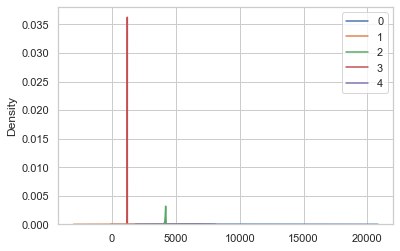

[6623, 0, 0, 0, 0]
[4913, 0, 0, 0, 0]
[104, 0, 4089, 0, 29]
[7, 0, 0, 1204, 0]
[4383, 0, 0, 0, 1812]


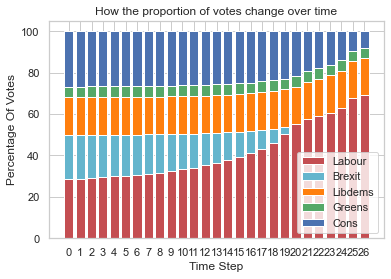

In [16]:
opinions = run(numParties, 'whole', opinions)
labour = [0,0,0,0,0]
brexit = [0,0,0,0,0]
libdems = [0,0,0,0,0]
greens = [0,0,0,0,0]
cons = [0,0,0,0,0]
for i in range(len(initialOpinions)):
    initialIndex = initialOpinions[i].index(max(initialOpinions[i]))
    newIndex = opinions[i].index(max(opinions[i]))
    if initialIndex == 0:
        labour[newIndex] += 1
    elif initialIndex == 1:
        brexit[newIndex] += 1
    elif initialIndex == 2:
        libdems[newIndex] += 1
    elif initialIndex == 3:
        greens[newIndex] += 1
    elif initialIndex == 4:
        cons[newIndex] += 1
print(labour)
print(brexit)
print(libdems)
print(greens)
print(cons)